## Violin Plots Based on Condition

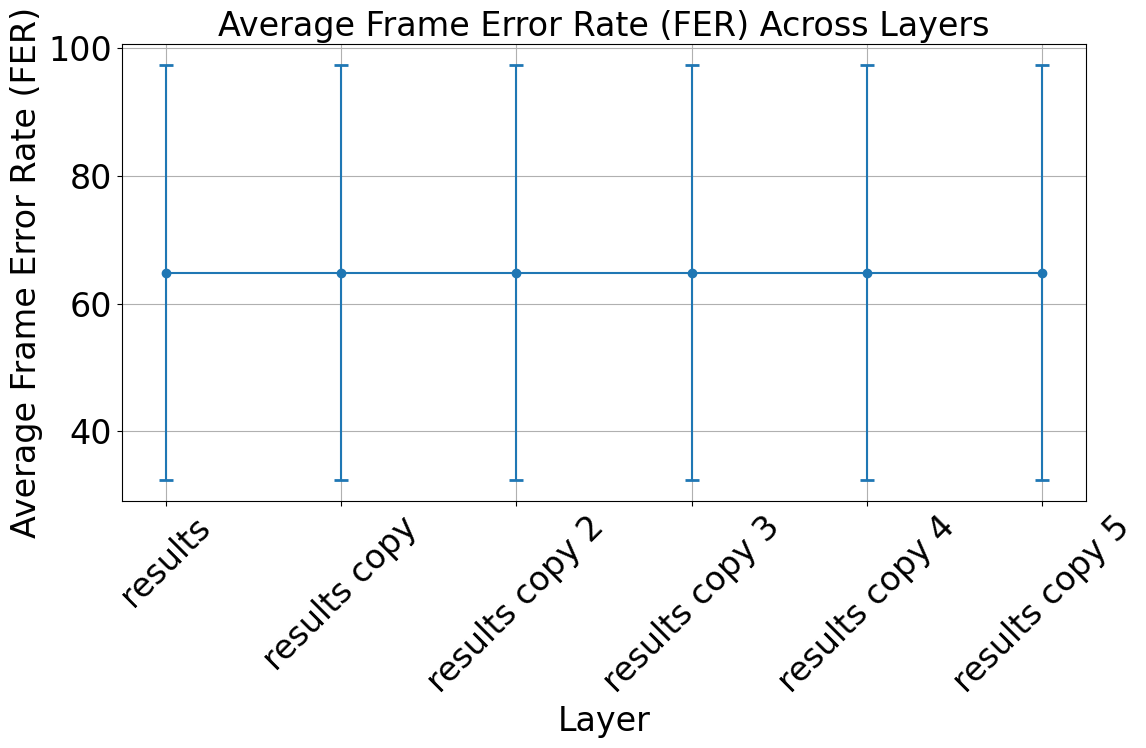

In [23]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Directories for the different conditions
conditions = ['spec_linear_probe', 'trained_linear_probe']
base_path = '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results'

# Initialize an empty list to store data
all_data = []

# Load JSON files and aggregate data
for cond in conditions:
    cond_path = os.path.join(base_path, cond)
    for filename in os.listdir(cond_path):
        if filename.endswith('.json'):
            filepath = os.path.join(cond_path, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                
                # Extract bird_id from filename
                bird_id = filename.split('.')[0]
                
                # Extract class FERs
                class_fer_dict = data.get('class_frame_error_rates', {})
                
                for class_label, fer in class_fer_dict.items():
                    all_data.append({
                        'Condition': cond,
                        'Class': class_label,
                        'FER': fer,
                        'Bird ID': bird_id
                    })

# Convert list of dictionaries to a DataFrame
df = pd.DataFrame(all_data)

# Ensure that 'Condition' is a categorical variable for better plotting
df['Condition'] = pd.Categorical(df['Condition'], categories=conditions)

# Sort data by Class for better visualization
df = df.sort_values(by=['Class'])

# Adjust plot settings for better spacing
plt.rcParams.update({'font.size': 24})  # Decrease overall font size

# Plot the violin plot with overlaid dot plots
plt.figure(figsize=(20, 12))

# Violin plot with different colors for each condition
sns.violinplot(x='Condition', y='FER', data=df, bw=0.2, cut=0, inner=None, palette='Set2', orient='v')

# Set y-axis limit to 100
plt.ylim(0, 100)

# Overlay scatter plot
bird_ids = df['Bird ID'].unique()
colors = sns.color_palette('husl', len(bird_ids))  # Generate different colors for bird IDs

for i, cond in enumerate(conditions):
    condition_data = df[df['Condition'] == cond]
    
    for j, bird_id in enumerate(bird_ids):
        bird_data = condition_data[condition_data['Bird ID'] == bird_id]
        # Scatter plot for each bird ID within the condition with increased dot size
        plt.scatter(np.random.normal(i, 0.08, size=len(bird_data)), bird_data['FER'], 
                    color=colors[j], alpha=0.8, s=100, label=f'Bird {bird_id}' if i == 0 else "")

    # Calculate statistics for annotation
    median = condition_data['FER'].median()
    std_dev = condition_data['FER'].std()

    # Annotate the plot above the violin plot but within the border
    plt.text(i, 95, f'Median: {median:.2f}', 
             ha='center', va='top', fontsize=18, color='black')  # Positioned near the top
    plt.text(i, 90, f'Std: {std_dev:.2f}', 
             ha='center', va='top', fontsize=18, color='black')  # Positioned slightly lower

# Set x-axis labels horizontal
plt.xticks(ticks=np.arange(len(conditions)), labels=conditions, rotation=0, fontsize=24)
plt.title('FER Distribution Across Conditions', fontsize=36, pad=30)
plt.xlabel('Condition', fontsize=30, labelpad=20)
plt.ylabel('Frame Error Rate (FER)', fontsize=30, labelpad=20)
plt.legend(title='Bird ID', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=24)
plt.grid(True)
plt.tight_layout(pad=5)

# Save plot if needed
# plt.savefig('fer_violin_plot_annotations_fixed.png', dpi=300)

plt.show()


## Layer Wise FER

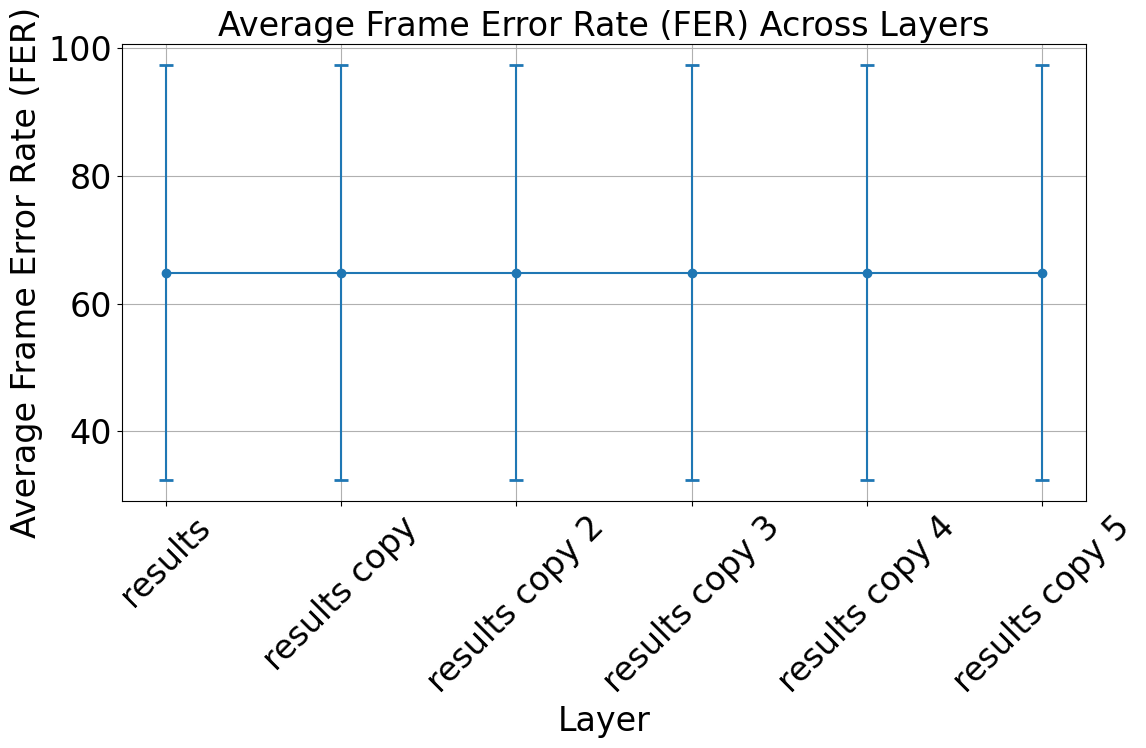

In [21]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory containing JSON files for each layer
results_dir = '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/layer_results'

# Initialize lists to store data for plotting
layers = []
average_fer = []
std_fer = []

# Load JSON files and compute average FER and std deviation for each layer
for filename in sorted(os.listdir(results_dir)):
    if filename.endswith('.json'):
        filepath = os.path.join(results_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            
            # Extract layer name from filename (assuming filename format: "layer_name.json")
            layer_name = filename.split('.')[0]
            
            # Extract FERs for all classes in this layer
            class_fer_dict = data.get('class_frame_error_rates', {})
            fer_values = list(class_fer_dict.values())
            
            # Compute average and std deviation of FER for this layer
            avg_fer = np.mean(fer_values)
            std_dev_fer = np.std(fer_values)
            
            # Store computed values for plotting
            layers.append(layer_name)
            average_fer.append(avg_fer)
            std_fer.append(std_dev_fer)

# Convert to DataFrame for easier handling
df = pd.DataFrame({
    'Layer': layers,
    'Average FER': average_fer,
    'Std Dev FER': std_fer
})

# Sort DataFrame by the string representation of layers
df = df.sort_values('Layer')

# Plotting the line plot with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(df['Layer'], df['Average FER'], yerr=df['Std Dev FER'], fmt='-o', capsize=5, capthick=2)

plt.title('Average Frame Error Rate (FER) Across Layers', fontsize=24)
plt.xlabel('Layer', fontsize=24)
plt.ylabel('Average Frame Error Rate (FER)', fontsize=24)
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.tight_layout()

# Save plot if needed
plt.savefig('fer_line_plot_across_layers.png', dpi=300)

plt.show()
